In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot

import shap
from catboost import CatBoostRegressor, Pool

plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)

pyplot.rcParams["figure.figsize"] = (20,10)

In [3]:
import matplotlib.pyplot as plt
def trading(forecast,actual):
#execute the trading from the result of forecast and actual energy production
#forecast: an 1D array of forecast values (Unit:kWh)
#actual: an 1D array of actual values (Unit:kWh)
  
    #initial budget
    budget=1e9
    #counters initialize: short falling and panalty counter
    SFcount=0;
    Pcount=0;
    cashFlow=[1e9]
    
    for f,a in zip(forecast,actual):
        if f <= a:
            budget += f*10
        elif f > a:#short falling
            #calculate cost of spot price energy
            budget += a*10
            spotP = 20*(f-a)
            SFcount+= 1
            if budget >= spotP:
                budget -= 20*(f-a)
            else:
                #receive penalty from the government
                if budget>0:
                    #buy from grid if budget not equal to 0
                    spotP-=budget
                    budget=0
                #fine =5* spotP
                budget -= 5*spotP
                Pcount+=1
        cashFlow.append(budget)
    timeStep= list(range(0, len(cashFlow)))
    #Reporting
    plt.plot(timeStep,cashFlow)
    plt.show()
    print ("resultant budget: ",budget)
    print ("net profit: ",budget-1e9)
    print ("number of short falling: ",SFcount )
    print ("number of panalty: ",Pcount )
    #print ("Cash flow: ",cashFlow )

In [4]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
data = pd.read_csv("combined_energy_data.csv", low_memory=False)

In [6]:
data = data.drop_duplicates(subset=['datetime'])

In [7]:
data['datetime'] = data['datetime'].apply(lambda x: x.split("+")[0])

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [9]:
columns_use = ['datetime','Wind', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']

In [10]:
#agg_df = df[['datetime','Wind']].groupby([df['datetime'].dt.floor('H')]).agg(['mean','sum','std'])
#agg_df.columns = agg_df.columns.map('_'.join)
#agg_df = agg_df.reset_index()
#merge_df = agg_df.merge(df[columns_use], how='left', on='datetime')
#merge_df = merge_df.fillna(method='ffill')

In [11]:
#data = merge_df.copy()

In [12]:
data = data[columns_use].fillna(method='ffill')

In [13]:
data.dropna(inplace=True)

In [14]:
window = 29 
lag_size = 18
lag = lag_size

In [15]:
series = series_to_supervised(data, window=window, lag=lag).reset_index(drop=True)

In [16]:
datetime_t0 = series['datetime(t)']

In [17]:
datetime_cols = [c for c in series.columns if 'datetime' in c]

In [18]:
series.drop(datetime_cols, axis=1, inplace=True)

In [19]:
series['datetime'] = datetime_t0

In [20]:
series['hour'] = series['datetime'].dt.hour
series['dayofweek'] = series['datetime'].dt.dayofweek
series['quarter'] = series['datetime'].dt.quarter
series['month'] = series['datetime'].dt.month
series['year'] = series['datetime'].dt.year 
series['dayofyear'] = series['datetime'].dt.dayofyear
series['dayofmonth'] = series['datetime'].dt.day
series['weekofyear'] = series['datetime'].dt.weekofyear

In [21]:
plt.rcParams["figure.figsize"] = (20, 9)

In [22]:
scaler = StandardScaler()

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [24]:
y_train = series[series.year.isin([2017,2018])][['Wind(t+18)']]
y_test = series[series.year.isin([2019])][['Wind(t+18)']]
y_holdout = series[series.year.isin([2020])][['Wind(t+18)']]

In [25]:
leak_cols = [c for c in series.columns if '(t+%d)' % lag_size in c]

In [26]:
series.drop(leak_cols, axis=1, inplace=True)

In [29]:
list(series.columns)

['Wind(t-29)',
 'guitrancourt_Speed(m/s)(t-29)',
 'guitrancourt_Direction (deg N)(t-29)',
 'lieusaint_Speed(m/s)(t-29)',
 'lieusaint_Direction (deg N)(t-29)',
 'lvs-pussay_Speed(m/s)(t-29)',
 'lvs-pussay_Direction (deg N)(t-29)',
 'parc-du-gatinais_Speed(m/s)(t-29)',
 'parc-du-gatinais_Direction (deg N)(t-29)',
 'arville_Speed(m/s)(t-29)',
 'arville_Direction (deg N)(t-29)',
 'boissy-la-riviere_Speed(m/s)(t-29)',
 'boissy-la-riviere_Direction (deg N)(t-29)',
 'angerville-1_Speed(m/s)(t-29)',
 'angerville-1_Direction (deg N)(t-29)',
 'angerville-2_Speed(m/s)(t-29)',
 'angerville-2_Direction (deg N)(t-29)',
 'guitrancourt-b_Speed(m/s)(t-29)',
 'guitrancourt-b_Direction (deg N)(t-29)',
 'lieusaint-b_Speed(m/s)(t-29)',
 'lieusaint-b_Direction (deg N)(t-29)',
 'lvs-pussay-b_Speed(m/s)(t-29)',
 'lvs-pussay-b_Direction (deg N)(t-29)',
 'parc-du-gatinais-b_Speed(m/s)(t-29)',
 'parc-du-gatinais-b_Direction (deg N)(t-29)',
 'arville-b_Speed(m/s)(t-29)',
 'arville-b_Direction (deg N)(t-29)',
 'boissy-la-riviere-b_Speed(m/s)(t-29)',
 'boissy-la-riviere-b_Direction (deg N)(t-29)',
 'angerville-1-b_Speed(m/s)(t-29)',
 'angerville-1-b_Direction (deg N)(t-29)',
 'angerville-2-b_Speed(m/s)(t-29)',
 'angerville-2-b_Direction (deg N)(t-29)',
 'Wind(t-28)',
 'guitrancourt_Speed(m/s)(t-28)',
 'guitrancourt_Direction (deg N)(t-28)',
 'lieusaint_Speed(m/s)(t-28)',
 'lieusaint_Direction (deg N)(t-28)',
 'lvs-pussay_Speed(m/s)(t-28)',
 'lvs-pussay_Direction (deg N)(t-28)',
 'parc-du-gatinais_Speed(m/s)(t-28)',
 'parc-du-gatinais_Direction (deg N)(t-28)',
 'arville_Speed(m/s)(t-28)',
 'arville_Direction (deg N)(t-28)',
 'boissy-la-riviere_Speed(m/s)(t-28)',
 'boissy-la-riviere_Direction (deg N)(t-28)',
 'angerville-1_Speed(m/s)(t-28)',
 'angerville-1_Direction (deg N)(t-28)',
 'angerville-2_Speed(m/s)(t-28)',
 'angerville-2_Direction (deg N)(t-28)',
 'guitrancourt-b_Speed(m/s)(t-28)',
 'guitrancourt-b_Direction (deg N)(t-28)',
 'lieusaint-b_Speed(m/s)(t-28)',
 'lieusaint-b_Direction (deg N)(t-28)',
 'lvs-pussay-b_Speed(m/s)(t-28)',
 'lvs-pussay-b_Direction (deg N)(t-28)',
 'parc-du-gatinais-b_Speed(m/s)(t-28)',
 'parc-du-gatinais-b_Direction (deg N)(t-28)',
 'arville-b_Speed(m/s)(t-28)',
 'arville-b_Direction (deg N)(t-28)',
 'boissy-la-riviere-b_Speed(m/s)(t-28)',
 'boissy-la-riviere-b_Direction (deg N)(t-28)',
 'angerville-1-b_Speed(m/s)(t-28)',
 'angerville-1-b_Direction (deg N)(t-28)',
 'angerville-2-b_Speed(m/s)(t-28)',
 'angerville-2-b_Direction (deg N)(t-28)',
 'Wind(t-27)',
 'guitrancourt_Speed(m/s)(t-27)',
 'guitrancourt_Direction (deg N)(t-27)',
 'lieusaint_Speed(m/s)(t-27)',
 'lieusaint_Direction (deg N)(t-27)',
 'lvs-pussay_Speed(m/s)(t-27)',
 'lvs-pussay_Direction (deg N)(t-27)',
 'parc-du-gatinais_Speed(m/s)(t-27)',
 'parc-du-gatinais_Direction (deg N)(t-27)',
 'arville_Speed(m/s)(t-27)',
 'arville_Direction (deg N)(t-27)',
 'boissy-la-riviere_Speed(m/s)(t-27)',
 'boissy-la-riviere_Direction (deg N)(t-27)',
 'angerville-1_Speed(m/s)(t-27)',
 'angerville-1_Direction (deg N)(t-27)',
 'angerville-2_Speed(m/s)(t-27)',
 'angerville-2_Direction (deg N)(t-27)',
 'guitrancourt-b_Speed(m/s)(t-27)',
 'guitrancourt-b_Direction (deg N)(t-27)',
 'lieusaint-b_Speed(m/s)(t-27)',
 'lieusaint-b_Direction (deg N)(t-27)',
 'lvs-pussay-b_Speed(m/s)(t-27)',
 'lvs-pussay-b_Direction (deg N)(t-27)',
 'parc-du-gatinais-b_Speed(m/s)(t-27)',
 'parc-du-gatinais-b_Direction (deg N)(t-27)',
 'arville-b_Speed(m/s)(t-27)',
 'arville-b_Direction (deg N)(t-27)',
 'boissy-la-riviere-b_Speed(m/s)(t-27)',
 'boissy-la-riviere-b_Direction (deg N)(t-27)',
 'angerville-1-b_Speed(m/s)(t-27)',
 'angerville-1-b_Direction (deg N)(t-27)',
 'angerville-2-b_Speed(m/s)(t-27)',
 'angerville-2-b_Direction (deg N)(t-27)',
 'Wind(t-26)',
 'guitrancourt_Speed(m/s)(t-26)',
 'guitrancourt_Direction (deg N)(t-26)',
 'lieusaint_Speed(m/s)(t-26)',
 'lieusaint_Direction (deg N)(t-26)',
 'lvs-pussay_Speed(m/s)(t-26)',
 'lvs-pussay_Direction (deg N)(t-26)',
 'parc-du-gatinais_Speed(m/s)(t-26)',
 'p

In [29]:
X_train = scaler.fit_transform(series[series.year.isin([2017,2018])].drop(columns=['datetime','year','month']))
X_test = scaler.transform(series[series.year.isin([2019])].drop(columns=['datetime','year','month']))
X_holdout = scaler.transform(series[series.year.isin([2020])].drop(columns=['datetime','year','month']))

In [30]:
#X_train = series[series.year.isin([2017,2018])].drop(columns=['datetime','year','month']).values
#X_test = series[series.year.isin([2019])].drop(columns=['datetime','year','month']).values
#X_holdout = series[series.year.isin([2020])].drop(columns=['datetime','year','month']).values

In [31]:
#X_train.drop(leak_cols, axis=1, inplace=True)
#X_test.drop(leak_cols, axis=1, inplace=True)
#X_holdout.drop(leak_cols, axis=1, inplace=True)

In [32]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_holdout_series = X_holdout.reshape((X_holdout.shape[0], X_holdout.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (70043, 996, 1)
Validation set shape (35036, 996, 1)


In [33]:
epochs = 40
batch = len(X_train_series)
lr = 0.0001
adam = optimizers.Adam(lr)

In [34]:
import keras.backend as K
def customLoss(true,pred):
    diff = pred - true

    greater = K.less_equal(diff,0)
    greater = K.cast(greater, K.floatx()) #0 for lower, 1 for greater
    #greater = greater + 1                 #1 for lower, 2 for greater

    #use some kind of loss here, such as mse or mae, or pick one from keras
    #using mse:
    return K.mean(greater*K.square(diff))

In [35]:
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, Activation, BatchNormalization

In [38]:
reg = Sequential()
reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
#reg.add(Dropout(0.5))
#reg.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
reg.add(MaxPooling1D(pool_size=2))
reg.add(BatchNormalization())       
reg.add(Flatten())
#reg.add(Dropout(0.5))
reg.add(Dense(50, activation='relu'))
reg.add(BatchNormalization())       
reg.add(Dense(1))
reg.compile(loss='mse', optimizer=adam)
reg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 995, 64)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 497, 64)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 497, 64)           256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 31808)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1590450   
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [39]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [40]:
cnn_history = reg.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2, callbacks=[early_stopping_monitor])

Epoch 1/40
2189/2189 - 25s - loss: 19873768.0000 - val_loss: 55044132.0000
Epoch 2/40
2189/2189 - 24s - loss: 19710764.0000 - val_loss: 54399748.0000
Epoch 3/40
2189/2189 - 24s - loss: 19486940.0000 - val_loss: 53803052.0000
Epoch 4/40
2189/2189 - 24s - loss: 19209200.0000 - val_loss: 52948264.0000
Epoch 5/40
2189/2189 - 24s - loss: 18879512.0000 - val_loss: 51977120.0000
Epoch 6/40
2189/2189 - 24s - loss: 18501074.0000 - val_loss: 51095108.0000
Epoch 7/40
2189/2189 - 24s - loss: 18076870.0000 - val_loss: 49709796.0000
Epoch 8/40
2189/2189 - 25s - loss: 17615034.0000 - val_loss: 48539348.0000
Epoch 9/40
2189/2189 - 25s - loss: 17106664.0000 - val_loss: 47125960.0000
Epoch 10/40
2189/2189 - 25s - loss: 16565942.0000 - val_loss: 45226680.0000
Epoch 11/40
2189/2189 - 24s - loss: 15991664.0000 - val_loss: 43603760.0000
Epoch 12/40
2189/2189 - 25s - loss: 15392639.0000 - val_loss: 42806176.0000
Epoch 13/40
2189/2189 - 25s - loss: 14751892.0000 - val_loss: 41229304.0000
Epoch 14/40
2189/2189

In [41]:
y_pred = reg.predict(X_test_series)

In [42]:
np.sqrt(mean_squared_error(y_test,y_pred))

3339.910097574847

In [43]:
mean_absolute_error(y_test,y_pred)

2360.5699869238606

In [44]:
series = series_to_supervised(data, window=window, lag=lag).reset_index(drop=True)

In [45]:
datetime_t0 = series['datetime(t)']

In [46]:
datetime_cols = [c for c in series.columns if 'datetime' in c]

In [47]:
series.drop(datetime_cols, axis=1, inplace=True)

In [48]:
series['datetime'] = datetime_t0

In [49]:
series['hour'] = series['datetime'].dt.hour
series['dayofweek'] = series['datetime'].dt.dayofweek
series['quarter'] = series['datetime'].dt.quarter
series['month'] = series['datetime'].dt.month
series['year'] = series['datetime'].dt.year 
series['dayofyear'] = series['datetime'].dt.dayofyear
series['dayofmonth'] = series['datetime'].dt.day
series['weekofyear'] = series['datetime'].dt.weekofyear

In [50]:
test_result = series[series.year.isin([2019])].copy()
test_result['prediction'] = y_pred

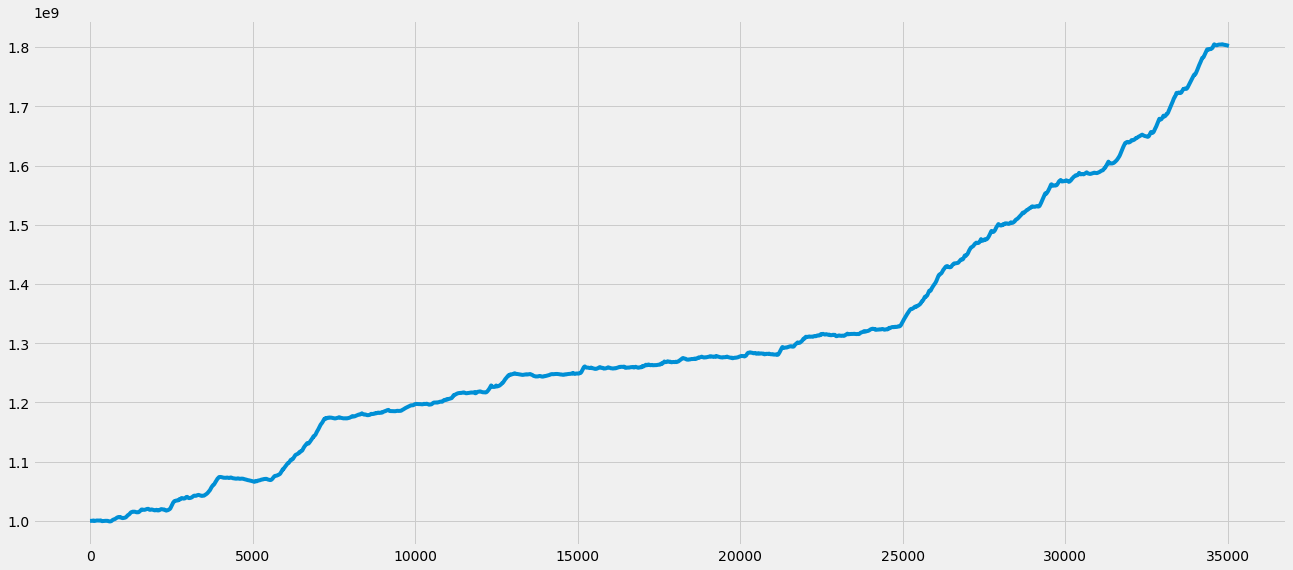

resultant budget:  1801950628.8484764
net profit:  801950628.8484764
number of short falling:  15736
number of panalty:  0


In [51]:
trading( test_result.prediction, test_result['Wind(t+18)'])

In [52]:
y_holdout_pred = reg.predict(X_holdout_series)

In [53]:
np.sqrt(mean_squared_error(y_holdout,y_holdout_pred))

4427.625546708768

In [54]:
mean_absolute_error(y_holdout,y_holdout_pred)

3222.713673201456

In [55]:
holdout_result = series[series.year.isin([2020])].copy()
holdout_result['prediction'] = y_holdout_pred

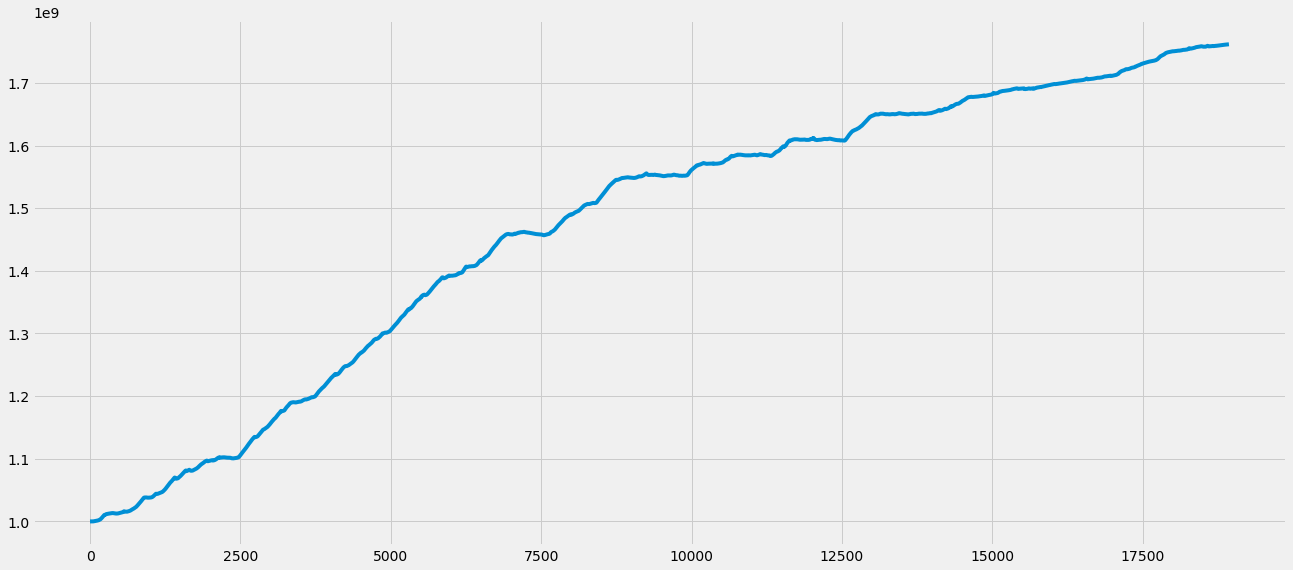

resultant budget:  1761577587.877841
net profit:  761577587.877841
number of short falling:  6284
number of panalty:  0


In [56]:
trading(holdout_result.prediction,holdout_result['Wind(t+18)'])

In [ ]:
test_result['wind_baseline']  = data.Wind.mean()

In [ ]:
trading(test_result['Wind(t+18)'], test_result.wind_baseline)

In [31]:
import urllib

In [44]:
predicted_value = str(4000)

In [45]:
url = "http://3.1.52.222/submit/pred?pwd=3423549827&value="

In [46]:
webUrl = urllib.request.urlopen(url + predicted_value)

In [47]:
data = webUrl.read()

In [48]:
data

b'Submitted \nReceived: 21-Jul-2020 09:53:06 UTC \nFor     : 22-Jul-2020 03:00:00 UTC \nValue   : 4000 \n'